¿Cómo se relaciona la edad de un individuo con su salario en el conjunto de datos proporcionado? Específicamente, ¿es posible predecir el salario de un individuo en función de su edad utilizando técnicas de ajuste de curva como la estimación spline?

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
data = pd.read_csv('Wage.csv')
data.head()

,ID,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


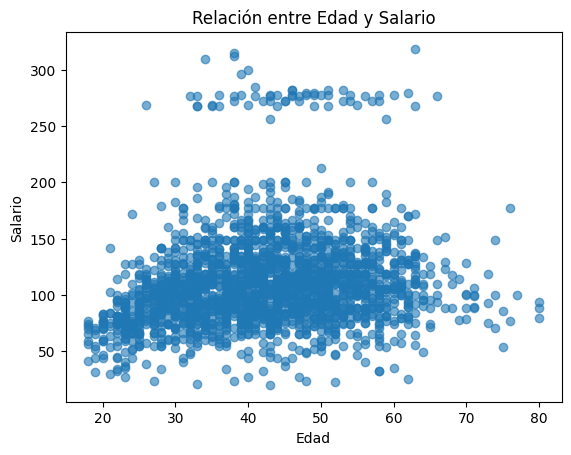

In [4]:
X = data['age']
y = data['wage']

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


plt.scatter(X_train,y_train, alpha=0.6)
plt.title('Relación entre Edad y Salario')
plt.xlabel('Edad')
plt.ylabel('Salario')
plt.show()


**Modelado**: Realizaremos una regresión polinomial, variando el grado del polinomio de 1 a 8. Esto nos permitirá comparar cómo cada modelo se ajusta a los datos y qué grado del polinomio podría ser el más adecuado para describir la relación.

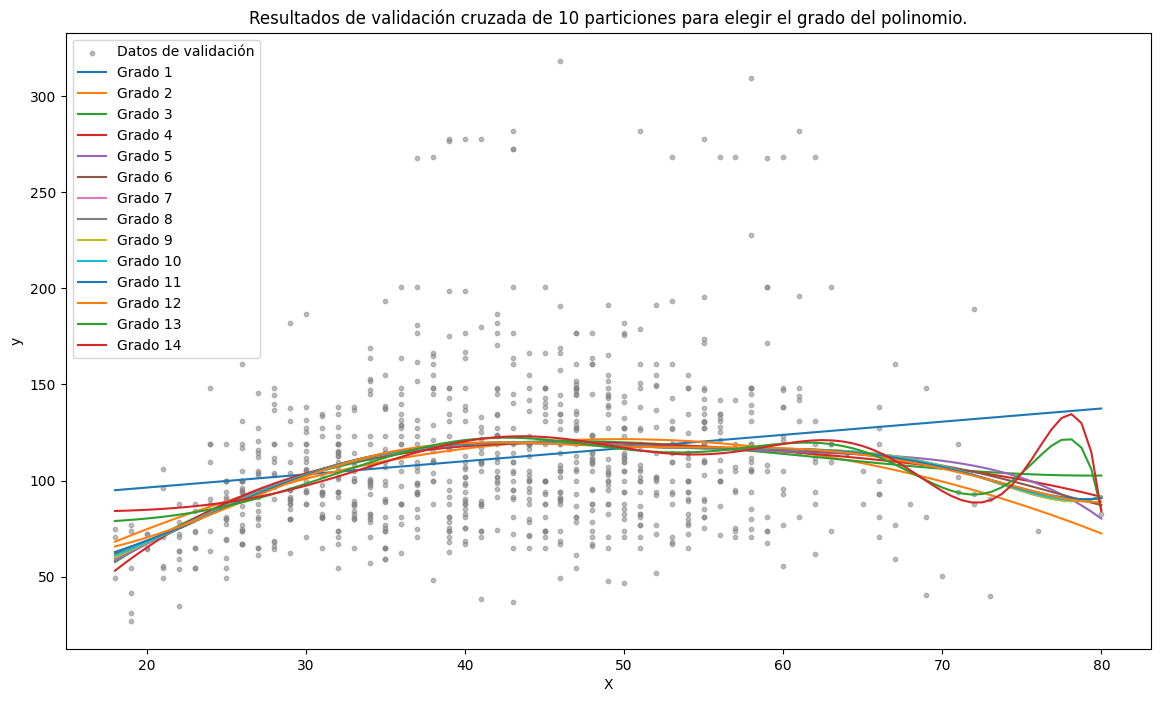

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

X_plot = np.linspace(min(X_train), max(X_train), 100).reshape(-1, 1)

# Inicializar la figura
plt.figure(figsize=(14, 8))

# Trazar los datos de validación
plt.scatter(X_val, y_val, s=10, color='gray', alpha=0.5, label="Datos de validación")

# Almacenar puntuaciones de entrenamiento
train_scores = []

# Ajustar modelos de regresión polinomial de grado 1 a 15
for i in range(1, 15):
    poly = PolynomialFeatures(degree=i)
    X_poly_train = poly.fit_transform(np.array(X_train).reshape(-1,1))

    X_poly_plot = poly.transform(X_plot)

    model = LinearRegression()

    # Calcular la puntuación de validación cruzada
    score = -np.mean(cross_val_score(model, X_poly_train, y_train, cv=10, scoring='neg_root_mean_squared_error'))
    train_scores.append(score)

    # Ajustar el modelo y realizar predicciones para trazar
    model.fit(X_poly_train, y_train)
    y_plot = model.predict(X_poly_plot)

    plt.plot(X_plot, y_plot, label=f"Grado {i}")

# Títulos y etiquetas
plt.title('Resultados de validación cruzada de 10 particiones para elegir el grado del polinomio.')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


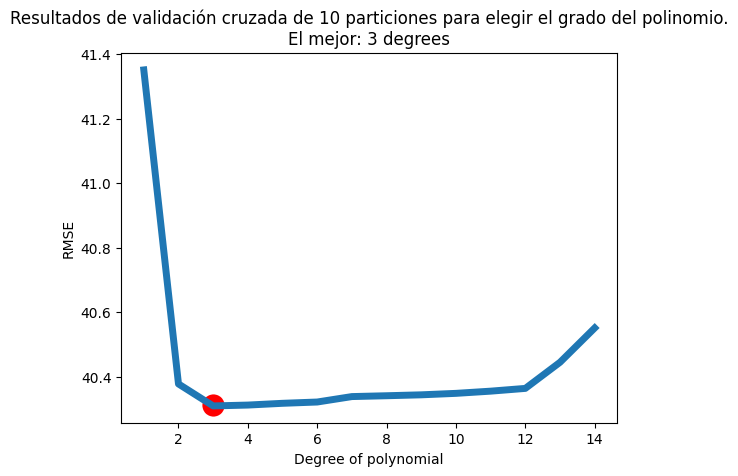

In [27]:
best_score = np.argmin(train_scores)+1
plt.plot(range(1,15), train_scores, linewidth=5)
plt.scatter(best_score, train_scores[best_score], c='red', linewidths=10)
plt.ylabel('RMSE')
plt.xlabel('Degree of polynomial')
plt.title('Resultados de validación cruzada de 10 particiones para elegir el grado del polinomio.\nEl mejor: %s degrees' % best_score)
plt.show()



**Análisis de Estimación Spline con Nodos Variables para Modelar la Relación entre Edad y Salario**

Tras haber explorado modelos polinomiales para entender la relación entre la edad y el salario, vamos a aplicar un enfoque diferente: la estimación spline. Este método nos permite tener más flexibilidad en el ajuste del modelo, especialmente en conjuntos de datos que presentan cambios no lineales y complejidades que los modelos polinomiales pueden no capturar de manera eficiente.

Metodología:
Utilizaremos la técnica de estimación spline con diferentes números de nodos (3, 5 y 8) para segmentar el rango de edades. Estos nodos actuarán como puntos de "quiebre" donde el modelo puede cambiar su forma, permitiendo un ajuste más flexible a los datos.

Preparación de Datos: Utilizaremos el mismo conjunto de datos dividido previamente en conjuntos de entrenamiento y validación.

Modelado: Aplicaremos estimación spline con 3, 4 y 5 nodos para modelar la relación entre la edad y el salario.

Evaluación del Modelo: Utilizaremos el Error Cuadrático Medio (MSE) para evaluar el rendimiento de cada modelo en el conjunto de validación.

Expectativas:
Esperamos que la estimación spline nos ofrezca un modelo que se ajuste de manera más precisa a las particularidades de los datos, capturando mejor las tendencias y cambios en la relación entre la edad y el salario.

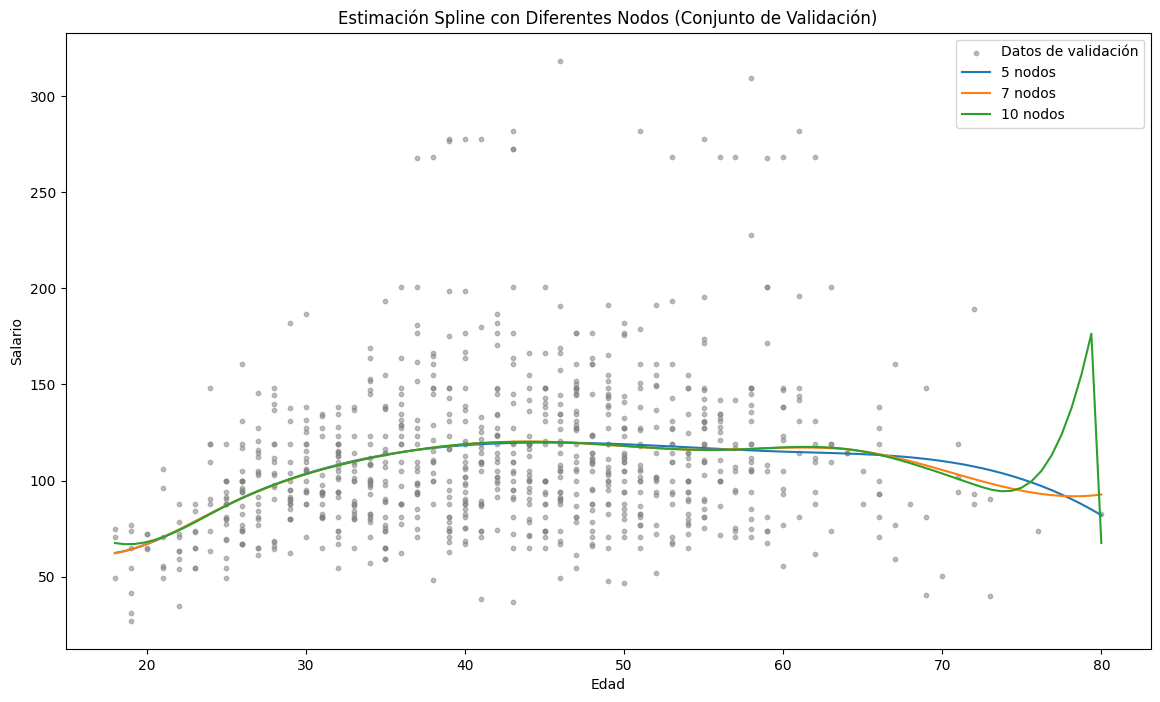

{5: 38.496003943564226, 7: 38.414395842032626, 10: 38.41687788664627}

In [44]:
from patsy import dmatrix

# Nodos para los splines con 3, 5 y 8 nodos
knots_list = [(25, 40, 60),  # 3 nodos
              (25, 35, 45, 55, 65),  # 5 nodos
              (25,33,41,49,56,64,72,80)]  # 8 nodos

spline_models = {}
spline_mse = {}

plt.figure(figsize=(14, 8))

plt.scatter(X_val, y_val, s=10, color='gray', alpha=0.5, label="Datos de validación")

for idx, knots in enumerate(knots_list):
    # Número de nodos
    num_nodes = len(knots) + 2


    # Matriz de diseño
    X_spline_train = dmatrix(f"bs(data, knots={knots}, degree=3, include_intercept=False)",
                         {"data": X_train.ravel()}, return_type='dataframe')
    X_spline_val = dmatrix(f"bs(data, knots={knots}, degree=3, include_intercept=False)",
                       {"data": X_val.ravel()}, return_type='dataframe')


    # Ajustamos el modelo de regresión lineal
    model_spline = LinearRegression()
    model_spline.fit(X_spline_train, y_train)

    spline_models[num_nodes] = model_spline

    y_spline_val_pred = model_spline.predict(X_spline_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_spline_val_pred))

    spline_mse[num_nodes] = rmse_val

    # Graficamos el modelo
    X_spline_plot = dmatrix(f"bs(data, knots={knots}, degree=3, include_intercept=False)",
                        {"data": X_plot.ravel()}, return_type='dataframe')

    y_spline_plot = model_spline.predict(X_spline_plot)
    plt.plot(X_plot, y_spline_plot, label=f"{num_nodes} nodos")

# Etiquetas y título
plt.xlabel("Edad")
plt.ylabel("Salario")
plt.title("Estimación Spline con Diferentes Nodos (Conjunto de Validación)")
plt.legend()
plt.show()

# Mostramos el MSE de validación para cada modelo spline
spline_mse



## Y ahora hacemos una estimacion spline cúbica natural




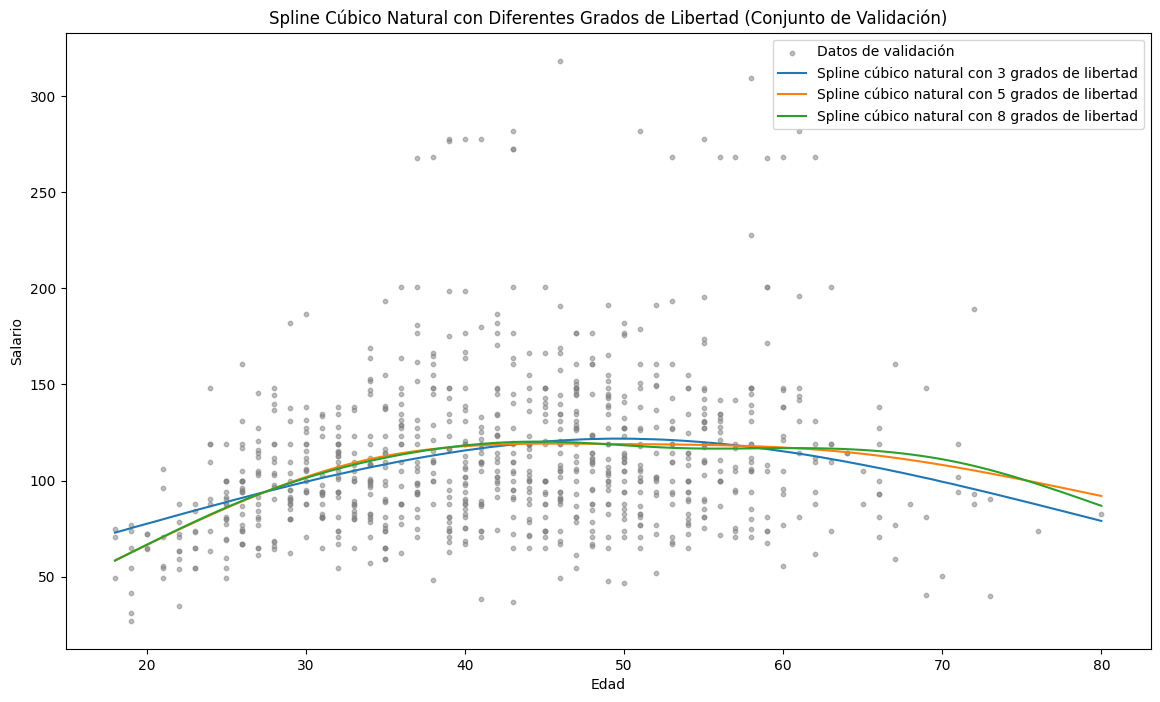

{3: 38.599182543196164, 5: 38.48383996690278, 8: 38.40365356662838}

In [48]:
plt.figure(figsize=(14, 8))

plt.scatter(X_val, y_val, s=10, color='gray', alpha=0.5, label="Datos de validación")

natural_spline_mse_es = {}

knot_colors = {3: 'red', 5: 'green', 8: 'blue'}

for df in [3, 5, 8]:
    # Crear matriz de diseño para el spline cúbico natural con Patsy
    # Nota: Usamos 'cr()' para el spline cúbico natural y especificamos df (grados de libertad)
    X_spline_train_natural = dmatrix(f"cr(data, df={df})",
                                     {"data": X_train.ravel()}, return_type='dataframe')

    # Ajustar el modelo de regresión lineal
    model_spline_natural = LinearRegression()
    model_spline_natural.fit(X_spline_train_natural, y_train)

    # Crear matriz de diseño para el conjunto de gráficos
    X_spline_plot_natural = dmatrix(f"cr(data, df={df})",
                                    {"data": X_plot.ravel()}, return_type='dataframe')

    # Realizar la predicción para el conjunto de gráficos
    y_spline_plot_natural = model_spline_natural.predict(X_spline_plot_natural)

    # Matriz de diseño para el conjunto de validación
    X_spline_val_natural = dmatrix(f"cr(data, df={df})",
                                   {"data": X_val.ravel()}, return_type='dataframe')

    y_spline_val_pred_natural = model_spline_natural.predict(X_spline_val_natural)
    rmse_val_natural = np.sqrt(mean_squared_error(y_val, y_spline_val_pred_natural))


    natural_spline_mse_es[df] = rmse_val_natural

    plt.plot(X_plot, y_spline_plot_natural, label=f"Spline cúbico natural con {df} grados de libertad")

plt.xlabel("Edad")
plt.ylabel("Salario")
plt.title("Spline Cúbico Natural con Diferentes Grados de Libertad (Conjunto de Validación)")
plt.legend()
plt.show()

natural_spline_mse_es


## **Ejercicio**

En el estudio de los factores que afectan los salarios, es esencial considerar múltiples variables que podrían tener un impacto en los ingresos de un individuo. Aunque hemos examinado previamente el efecto de la edad, otro factor crucial es el nivel de educación. En nuestro conjunto de datos, la variable "educación" se categoriza en cinco niveles distintos, desde menos que un graduado de secundaria hasta un grado avanzado. Dado que tanto la edad como la educación son variables significativas que podrían influir en el salario, sería interesante explorar un modelo de regresión con splines que incorpore ambas variables.
